Neste projeto irei criar um modelo com o objetivo de inibir ou evitar transações fraudulentas.

Projeto inspirado por: https://medium.com/@rafaelvendiciano/detec%C3%A7%C3%A3o-de-fraudes-em-cart%C3%B5es-de-cr%C3%A9dito-com-machine-learning-eec994792183

In [ ]:
!pip install scikit-plot
#Importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

#Configurar estilo dos gráficos com seaborn
sns.set_style('dark')

from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
f_cartao = pd.read_csv('"https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"')
df_cartao.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### Análise Exploratória

Olhando o DataFrame pode-se observar que as features foram descaracterizadas e transformadas em valores numéricos, sendo apenas as colunas Time e Amount preservadas.

### Class

Essa é a variável alvo do modelo, onde:
- 0: Transação normal
- 1: Transação fraudulenta

Farei uma análise dos valores dessa variável


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


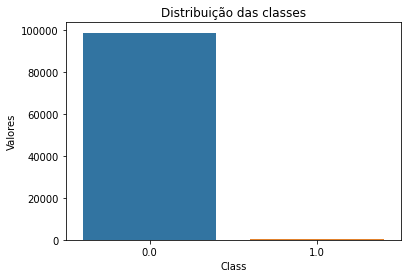

Proporção entre Transações Fraudulentas e Transações Normais:
0.0    0.99775
1.0    0.00224
Name: Class, dtype: float64


In [ ]:
fig, ax = plt.subplots()
sns.countplot('Class', data=df_cartao, ax=ax)
ax.set_title("Distribuição das classes")
ax.set_xlabel("Class")
ax.set_ylabel("Valores")
plt.show()

print("Proporção entre Transações Fraudulentas e Transações Normais:")
print(df_cartao['Class'].value_counts() / df_cartao.shape[0])

Grande discrepância entre a quantidade de fraudes e não fraudes.
De todos os valores, aproximadamente 0,22% são de fraudes.

Analisando a diferença no padrão das transações entre as variáveis Class e Amount.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


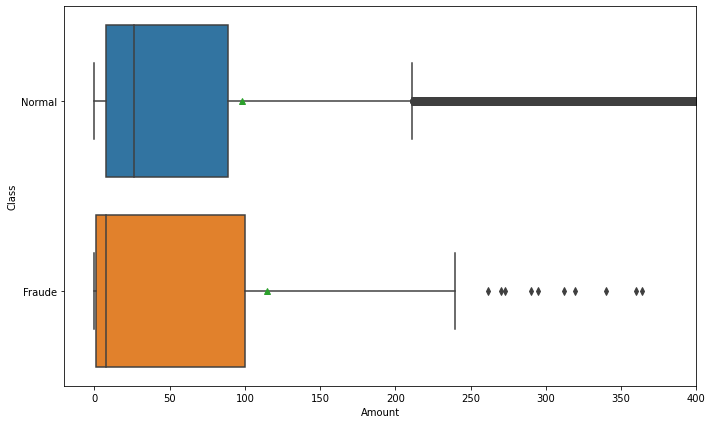

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
sns.boxplot(df_cartao.Amount, df_cartao.Class, showmeans=True, orient='h', ax=ax)
ax.set_xlim(((-20, 400)))
ax.set_yticks([0, 1])
ax.set_yticklabels(['Normal', 'Fraude'])
plt.tight_layout()

Há uma diferença nos padrões das transações fraudulentas. As transações normais possuem uma menor variação do quanto é transacionado, mas uma mediana alta.
Quanto ás operações fraudulentas, elas possuem uma variação maior e uma mediana menor.

Indo mais a fundo nas transações fraudulentas do Boxplot acima

In [ ]:
df_cartao[df_cartao.Class == 1]['Amount'].describe()

count     222.000000
mean      114.488243
std       255.373074
min         0.000000
25%         1.000000
50%         7.805000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

Nas transações fraudulentas tivemos média de aproximadamente 114, desvio padrão de 255 e máximo de 1809 sendo negociado.

Como esse números são de cartões europeus, provavelmente os números estão em euro.

### Gráfico de Densidade

Irei comparar a distribuição de cada variável para cada classe buscando detectar anomalias.


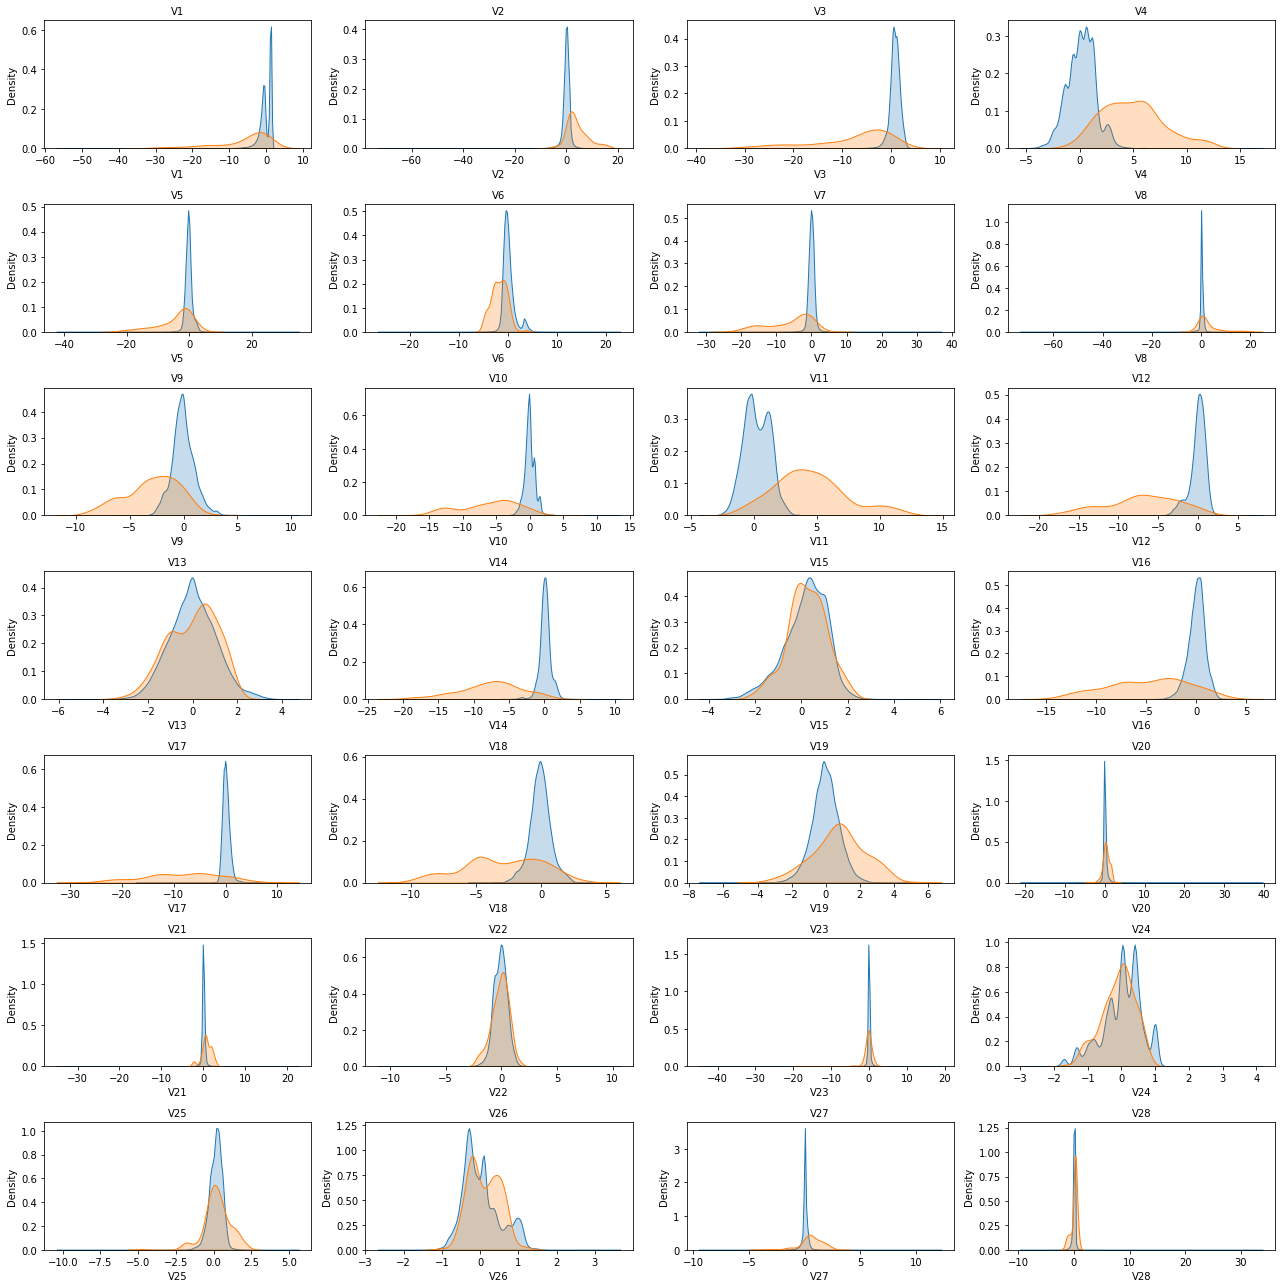

In [ ]:
column_names = df_cartao.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df_cartao[df_cartao.Class == 0]
df_class_1 = df_cartao[df_cartao.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18, 18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in columns_names:
  idx += 1
  plt.subplot(7, 4, idx)
  sns.kdeplot(df_class_0[col], label='Class 0', shade=True)
  sns.kdeplot(df_class_1[col], label='Class 1', shade=True)
  plt.title(col, fontsize=10)
plt.tight_layout()

Alguns pontos que podem ser considerados:
- O dataset está muito desbalanceado, com uma parcela muito pequena de trasanções fraudulentas.
- Apenas as colunas Time e Amount não estão padronizadas.

### Preparação dos Dados

Como as variáveis Time e Amount não estão padronizadas, farei agora.


In [ ]:
df_clean = df_cartao.copy()

scaler = StandardScaler()
df_clean['std_amount'] = scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis = 1, inplace=True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0,0.194147,-2.489091
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0,-0.359709,-2.489091
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0,1.057519,-2.489032
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0,0.095687,-2.489032
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0,-0.106020,-2.488973


In [ ]:
df_clean.isnull().sum()

V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           1
V22           1
V23           1
V24           1
V25           1
V26           1
V27           1
V28           1
Class         1
std_amount    1
std_time      0
dtype: int64

Ainda temos alguns valores em branco ou faltantes, com isso irei excluir essas linhas pois são poucos valores

In [ ]:
df_clean.dropna(inplace=True)

**Separando valores de treino e de teste**

In [ ]:
X = df_clean.drop('Class', axis = 1)
y = df_clean.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=2)

### **Balanceamento dos dados**

Através da biblioteca imblearn usarei a técnica Under-sampling para o balanceamento dos dados, preservando a classe minoritária.

1.0    167
0.0    167
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


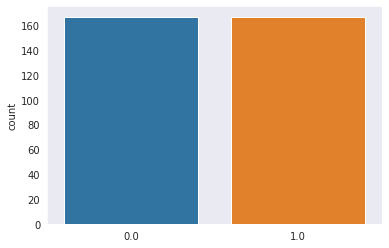

In [ ]:
rus = RandomUnderSampler(random_state=2)
X_rus, y_rus = rus.fit_sample(X_train, y_train)

print(pd.Series(y_rus).value_counts())

sns.countplot(y_rus);

Agora, com os dados balanceados, farei uma matriz de correlação para análise das relações entre variáveis.

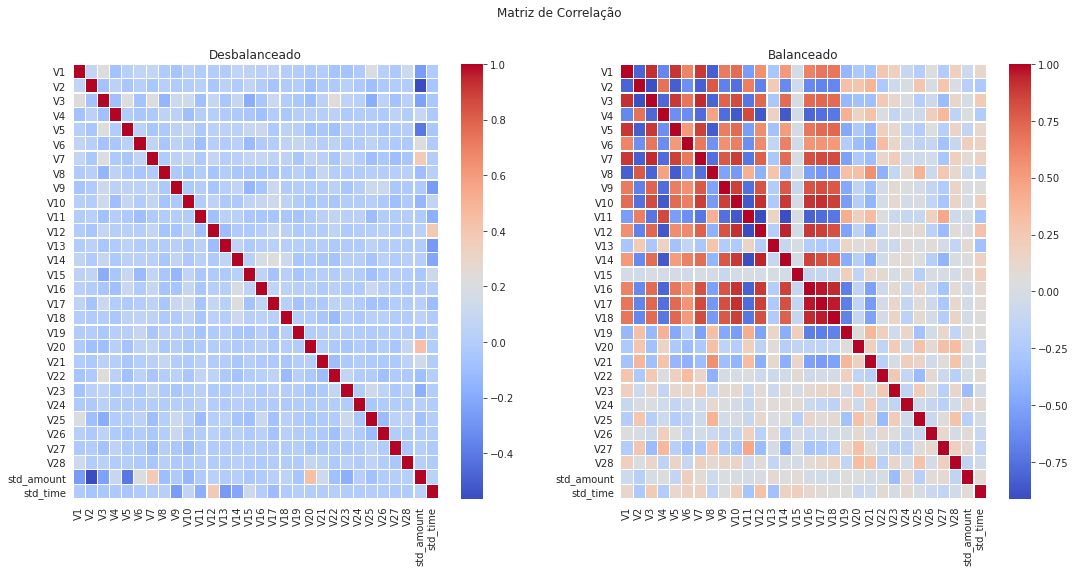

In [ ]:
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

### **Modelo de Machine Learning**

Relatório de Classificação (Regressão Logística):
               precision    recall  f1-score   support

         0.0     1.0000    0.9506    0.9746     24725
         1.0     0.0423    0.9818    0.0811        55

    accuracy                         0.9506     24780
   macro avg     0.5211    0.9662    0.5279     24780
weighted avg     0.9978    0.9506    0.9727     24780

Acurácia: 0.9506

AUC: 0.9662



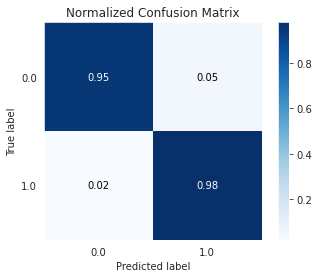

In [ ]:
#Regressão Logística
reg_log = LogisticRegression()

reg_log.fit(X_rus, y_rus)

y_pred1 = reg_log.predict(X_test)


#Avaliação do modelo
skplt.metrics.plot_confusion_matrix(y_test, y_pred1, normalize=True)

print('Relatório de Classificação (Regressão Logística):\n', classification_report(y_test, y_pred1, digits=4))

print(f'Acurácia: {accuracy_score(y_test, y_pred1):.4f}\n')

print(f'AUC: {roc_auc_score(y_test, y_pred1):.4f}\n')

### **Árvore de Decisão**

Relatório de Classificação (Árvore de Decisão):
               precision    recall  f1-score   support

         0.0     1.0000    0.9601    0.9796     24725
         1.0     0.0519    0.9818    0.0985        55

    accuracy                         0.9601     24780
   macro avg     0.5259    0.9709    0.5391     24780
weighted avg     0.9979    0.9601    0.9777     24780

Acurácia: 0.9601

AUC: 0.9709



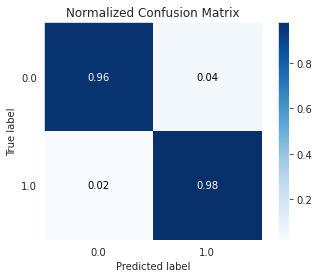

In [ ]:
#Árvore de Decisão
dec_tree = DecisionTreeClassifier(max_depth=4, criterion='entropy')

dec_tree.fit(X_rus, y_rus)

y_pred2 = dec_tree.predict(X_test)


skplt.metrics.plot_confusion_matrix(y_test, y_pred2, normalize=True)

print('Relatório de Classificação (Árvore de Decisão):\n', classification_report(y_test, y_pred2, digits=4))

print(f'Acurácia: {accuracy_score(y_test, y_pred2):.4f}\n')

print(f'AUC: {roc_auc_score(y_test, y_pred2):.4f}\n')

Como informado nos modelos acima, os dois modelos obtiveram acurácia alta (acima de 90%) e um AUC alto também, ótimos números para avaliar a qualidade geral dos modelos.
Entretanto, podemos observar que a 'precision' para 1 (Fraude) é baixa, ou seja, ocorre com frequência a detectação de falsas fraudes, com o cartão sendo bloqueado mas sem estar acontecendo uma fraude realmente.
Por outro lado, tivemos recalls muito bons, o que significa que o modelo detecta constantemente quando é fraude.

Um recall baixo significaria que o modelo detecta constantemente que não é fraude quando na verdade é fraude.

### **Conclusão**

Mesmo com um dataset limpo e organizado, deu para ver que o problema não é facil.

Com isso, abre uma margem para testar outros algoritmos de classificação, assim como otimizações de parâmetros futuramente.